<a href="https://colab.research.google.com/github/djrmarques/genetic_tsp/blob/master/TSP_Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simple genetic algorithm application on a TSP problem
Super simple genetic algorithm example to solve the TSP.


In [0]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
from itertools import starmap
from tqdm import tqdm
from numba import njit

## Create a simple TSP problem

In [0]:
max_coord =  50  # Upper limit of the coordinates
np.random.seed(50)

def create_cities(n_cities):
  """ Creates a random set of cities """
  city_coords = np.random.randint(1, max_coord, size=(n_cities, 2))
  distance_matrix = squareform(pdist(city_coords))
  return city_coords, distance_matrix

n_cities = 5
city_coords, distance_matrix = create_cities(n_cities)

### Show the distance matrix

In [62]:
distance_matrix

array([[ 0.  , 39.22, 15.13, 51.11, 28.23],
       [39.22,  0.  , 26.63, 39.62, 46.87],
       [15.13, 26.63,  0.  , 37.64, 24.33],
       [51.11, 39.62, 37.64,  0.  , 33.  ],
       [28.23, 46.87, 24.33, 33.  ,  0.  ]])

### Plot the cities


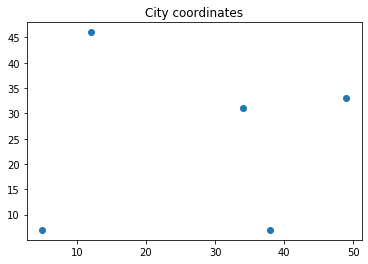

In [63]:
plt.scatter(city_coords[:, 0], city_coords[:, 1])
plt.title("City coordinates")
plt.show()

## Defining a chromosome and the fitness function
A solution is going to be defined by the sequence of the cities: 
- Example: [0, 2, 3, 1,4]
- The fitness of the solution is the total distance

**Objective is to minimize the distance**

In [64]:
def get_fitness(path):
  """ Calculates and returns the fitness value of a particular sequence """
  stacked_path = np.stack((path, np.roll(path, -1)))
  return distance_matrix[stacked_path[0, :], stacked_path[1, :]].sum()

# Defining an example path
example_path = np.array([0, 4, 2, 3, 1])
print(f"Path: {example_path} | Traveled Distance: {int(get_fitness(example_path))}")

Path: [0 4 2 3 1] | Traveled Distance: 169


## Defining crossover operation

A crossover operation will be used to combine two individuals and yield an offspring, sharing characteristics from both parents.





In [65]:
@njit
def crossover(sequence1, sequence2):
    """ Creates an offspring by mixing the genetic material of two parents """

    # Size of the chromosomes
    n_jobs = sequence1.shape[0]

    # Select two crossover points
    crossover_points = np.random.choice(n_jobs, 2)
    crossover_points.sort()
    c1, c2 = crossover_points

    # Create offspring
    new_sequence = sequence1.copy()
    for i in range(c1, c2):
        gen_to_change = sequence2[i]
        for j in range(n_jobs):
            if gen_to_change == new_sequence[j]:
                new_sequence[j] = new_sequence[i]
                new_sequence[i] = gen_to_change
                break

    return new_sequence

n_cities = 10

city_coords, distance_matrix = create_cities(n_cities)


# Create two parents
parent1 = np.arange(n_cities)
parent2 = parent1.copy()
np.random.shuffle(parent1)
np.random.shuffle(parent2)

# Create offpring
offspring = crossover(parent1, parent2)

# Assert that all the elements are unique
assert offspring.shape[0] == np.unique(offspring.shape[0])


print("Chromosomes")
print("Parent 1 :", parent1)
print("Parent 2 :", parent2)
print("Offspring:", offspring)

print("Fitness")
print("Parent 1  fitness:", round(get_fitness(parent1)))
print("Parent 2  fitness:", round(get_fitness(parent2)))
print("Offspring fitness:", round(get_fitness(offspring)))

Chromosomes
Parent 1 : [8 1 4 5 2 7 3 6 0 9]
Parent 2 : [6 1 5 0 7 8 4 2 9 3]
Offspring: [6 1 5 0 7 8 3 2 4 9]
Fitness
Parent 1  fitness: 268.0
Parent 2  fitness: 328.0
Offspring fitness: 256.0


## Selection Method
How are we going to select the parents to crossover?

- Roulete Wheel Selection: Fittest members are more likely to be chosen

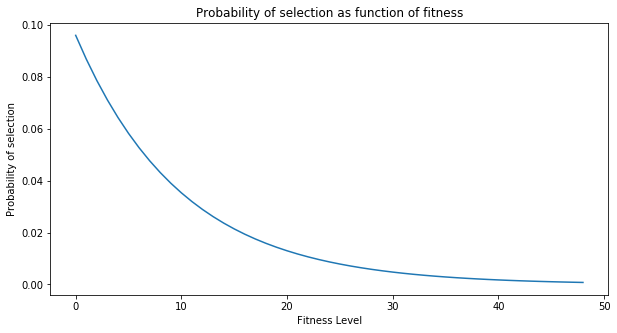

In [66]:
np.random.seed(50)
np.set_printoptions(precision=2)

fitness_array = np.arange(1, 50, 1, dtype=float)

# Define the selection pressure: Probabiltieis change over the genrations
beta=0.1
fitness_array *= -beta
probs = np.exp(fitness_array)
probs /= probs.sum()

# Plot
plt.figure(figsize=(10, 5))
lines = plt.plot(probs)
plt.xlabel("Fitness Level")
plt.ylabel("Probability of selection")
plt.title("Probability of selection as function of fitness")
plt.show()

## Run Genetic algorithm

1. Create Random Population
2. Evalute Fitness
3. Select Parents
4. Apply Crossover operation on parents until a new generation is created
3. Repeat 2-4 until generation limit


### Create new set of cities

In [0]:
# Creating a new city
np.random.seed(42)

n_cities = 20

# New city coordinates and distance matrix
city_coords, distance_matrix = create_cities(n_cities)

### Solve with genetic algorithm

100%|██████████| 300/300 [08:43<00:00,  1.72s/it]


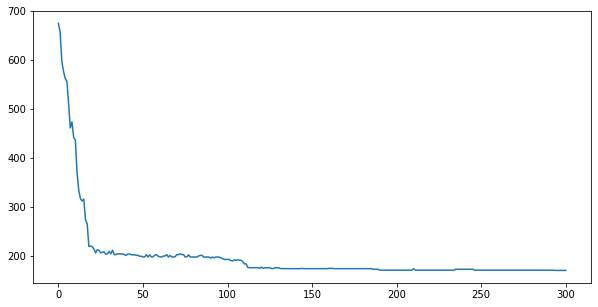

In [68]:
np.random.seed()

# Genetic algorithm parameters
n_pop = 30000
n_its = 300

# Creates initial population 
population = np.tile(np.arange(n_cities), (n_pop, 1))
np.apply_along_axis(arr=population, func1d=np.random.shuffle, axis=1)

# Fitness per generation placeholder array
fitness_per_generation = np.zeros(n_its + 1)

# Evaluate the fitness of every member of the population
fitness_list = np.apply_along_axis(arr=population, func1d=get_fitness, axis=1)

# Get the best element
best_element_id = np.argmax(fitness_list)

# Save best fitness and best solution
best_fitness = fitness_list[best_element_id]
best_solution = population[best_element_id]

# Save the best fitness 
fitness_per_generation[0] = best_fitness

# Start genetic algorithm
for i in tqdm(range(1, n_its+1)):

  # Select the parents. Members with lower fitness will be more likely to be chosen
  selection_pressure = -0.05
  fitness_list *= selection_pressure
  probs = np.exp(fitness_list)
  probs /= probs.sum()

  # Select the parents based on the probability
  parents_index = np.random.choice(np.arange(n_pop), p=probs, size=(n_pop, 2))
  parents = population[parents_index]

  # Create new generation
  population = np.array(list(starmap(crossover, parents)))
  # Evaluate the fitness of every member of the population
  fitness_list = np.apply_along_axis(arr=population, func1d=get_fitness, axis=1)

  # Get the best element
  best_element_id = np.argmax(fitness_list)
  generation_best_fitness = fitness_list[best_element_id]

  # Append best element to fittest by generation
  fitness_per_generation[i] = generation_best_fitness

  # Saves the best results
  if generation_best_fitness < best_fitness:
    best_fitness = generation_best_fitness
    best_solution = population[best_element_id]

  # print(f"Generation {i} | Fitness: {generation_best_fitness}")

plt.figure(figsize=(10, 5))
plt.plot(fitness_per_generation)
plt.show()

## View the final result

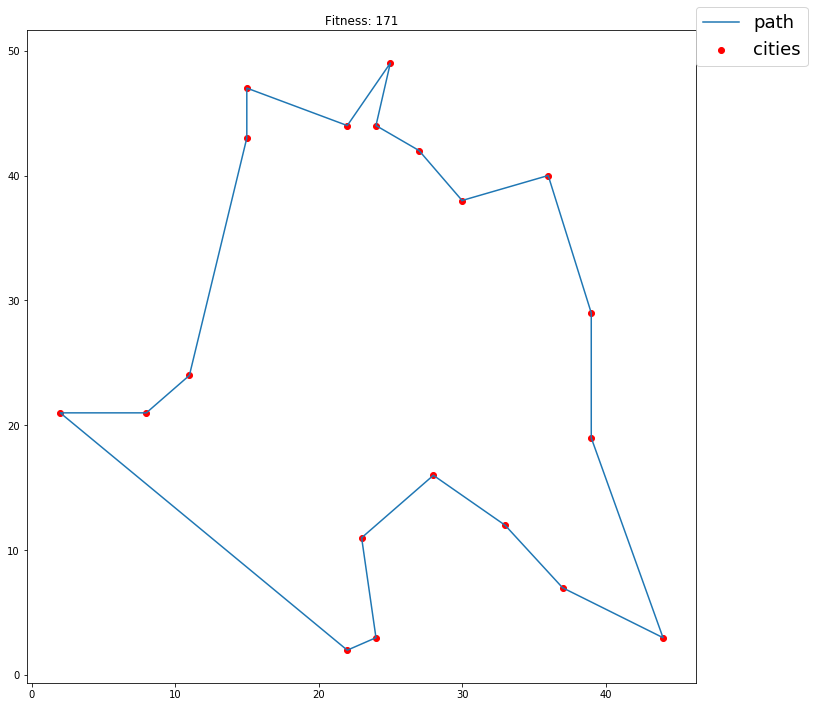

In [69]:
plt.figure(figsize=(12, 12))
x = np.append(city_coords[best_solution][:, 0], city_coords[best_solution][:, 0][0])
y = np.append(city_coords[best_solution][:, 1], city_coords[best_solution][:, 1][0])
plt.plot(x, y, label="path")
plt.scatter(city_coords[:, 0], city_coords[:, 1], c="red", label="cities")
plt.title(f"Fitness: {int(best_fitness)}")
plt.legend(fontsize=18, bbox_to_anchor=(1.18, 1.05))
plt.show()